In [6]:
from api_key import API_KEY
from mistralai.client import MistralClient
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import KernelPCA
import polars as pl
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [7]:
client = MistralClient(api_key=API_KEY)

embeddings_batch_response = client.embeddings(
    model="mistral-embed",
    input=["Embed this sentence.", "As well as this one."],
)

In [9]:
sentences = (
    pl.read_csv(
    source=r"C:\Users\faune\Downloads\FinancialPhraseBank-v1.0\FinancialPhraseBank-v1.0\Sentences_AllAgree.txt",
    separator="\t",
    ignore_errors=True,
    has_header=False
    )
    .rename({'column_1': 'sentences'})
    .select(pl.col('sentences').str.split('@').list.to_struct()).unnest('sentences')
    .rename({'field_0': 'sentences', 'field_1':'label'})
    .drop_nulls()
)


In [10]:
def get_embeddings_by_chunks(data: list, chunk_size: int):
    chunks = [data[x : x + chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [
        client.embeddings(model="mistral-embed", input=c) for c in chunks
    ]
    return [d.embedding for e in embeddings_response for d in e.data]

sentences = sentences.with_columns(pl.Series(name='embeddings', values= get_embeddings_by_chunks(sentences.select('sentences').to_series().to_list(), 50)))
sentences.head()

sentences,label,embeddings
str,str,list[f64]
"""According to G…","""neutral""","[-0.028625, 0.000851, … 0.015053]"
"""For the last q…","""positive""","[-0.037231, -0.005157, … 0.019821]"
"""In the third q…","""positive""","[-0.047729, 0.002062, … 0.01889]"
"""Operating prof…","""positive""","[-0.049011, 0.009354, … 0.014511]"
"""Operating prof…","""positive""","[-0.05014, 0.00362, … 0.013725]"


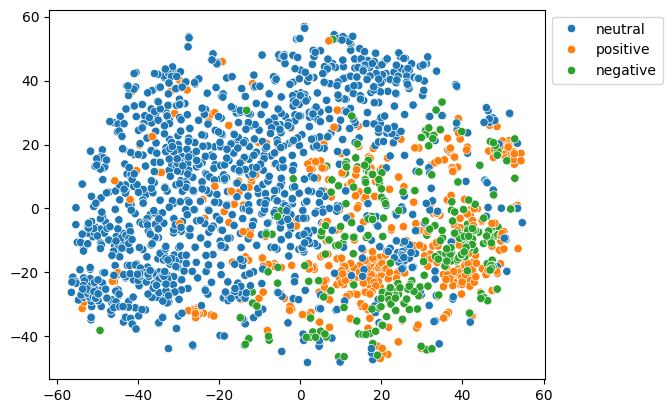

In [11]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(sentences.select('embeddings').to_series().to_list()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(sentences.select('label').to_series().to_list()))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [12]:
model = KMeans(n_clusters=3, max_iter=1000)
model.fit(sentences.select('embeddings').to_series().to_list())
sentences = sentences.with_columns(pl.Series(name='cluster', values=model.labels_))

<Axes: xlabel='cluster', ylabel='Count'>

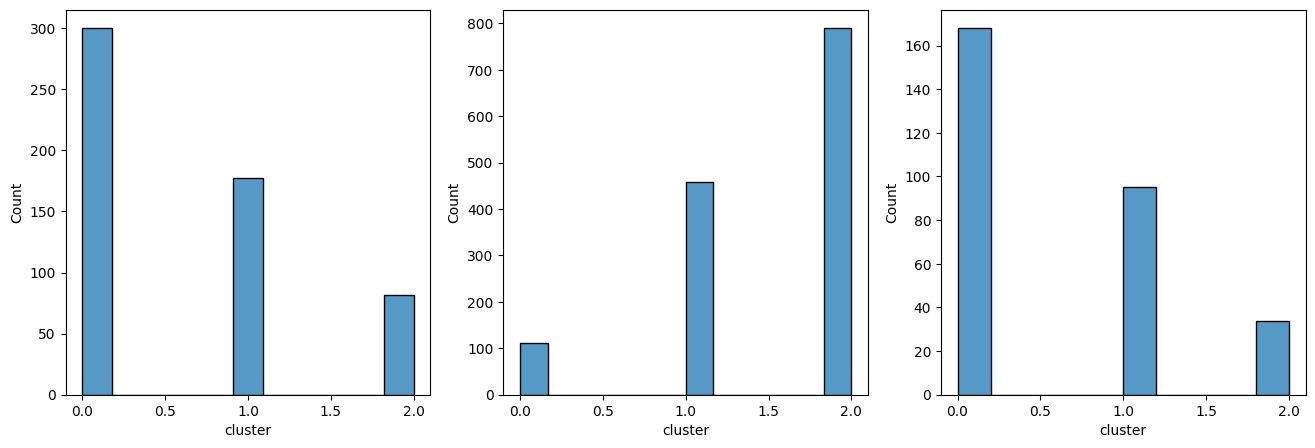

In [13]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(16,5)
sns.histplot(sentences.filter(pl.col('label').eq('positive')).to_pandas(), x='cluster', ax=axes[0])
sns.histplot(sentences.filter(pl.col('label').eq('neutral')).to_pandas(), x='cluster', ax=axes[1])
sns.histplot(sentences.filter(pl.col('label').eq('negative')).to_pandas(), x='cluster', ax=axes[2])

In [16]:
def get_pieplot(label: str, frame: pl.DataFrame,axs: list, ax: int) -> None:
    frame_pie = frame.filter(pl.col('label').eq(label)).group_by('cluster').agg(pl.col('label').count()).select(pl.col('cluster').cast(pl.String), pl.col('label'))
    category_colors = {'0': '#A0DDFF', '1': '#758ECD', '2': '#C1CEFE'}
    labels = category_colors.keys()
    colors = [category_colors[label] for label in labels]
    axs[ax].pie(
        x= frame_pie.select('label').to_series().to_pandas(), 
        labels= labels, # frame_pie.select('cluster').to_series().to_pandas(), 
        autopct='%1.1f%%', 
        colors= colors,
        startangle=90)
    axs[ax].axis('equal')
    axs[ax].set_title(f"{label.title()} labeled sentences by cluster")
    return None

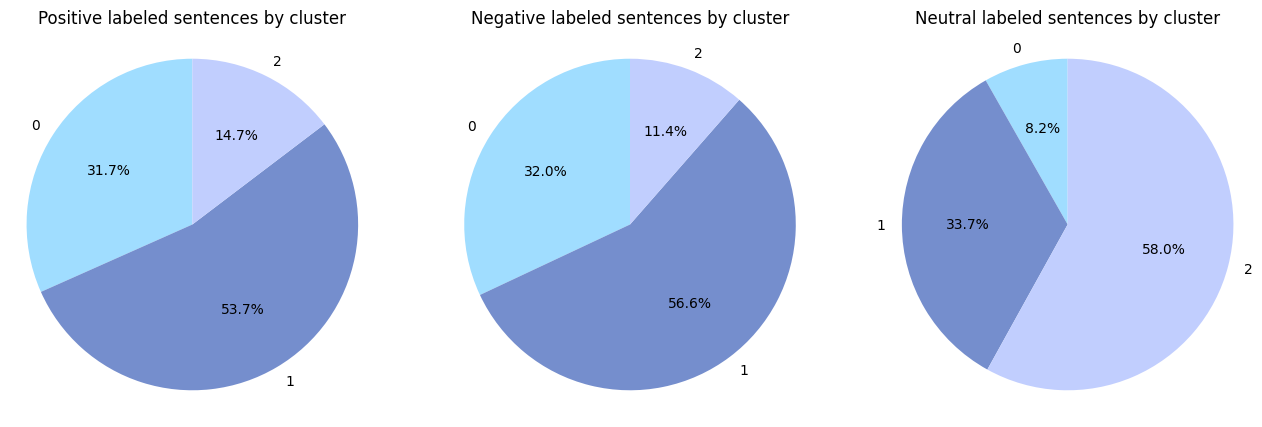

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
get_pieplot(label='positive', frame=sentences, ax=0, axs=axs)
get_pieplot(label='negative', frame=sentences, ax=1, axs=axs)
get_pieplot(label='neutral', frame=sentences, ax=2, axs=axs)

plt.show()